# K-Nearest Neighbors Classifier

In [22]:
import pickle

data = pickle.load( open( "../data/data_preprocessing.p", "rb" ) )
data.head()

,patient_nbr,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_disposition_id_grouped_EndOfLife,discharge_disposition_id_grouped_HomeDischarge,discharge_disposition_id_grouped_HomeWFollowUp,discharge_disposition_id_grouped_InstitutionalCare,discharge_disposition_id_grouped_Unknown,admission_source_grouped_Births,admission_source_grouped_Data_Issues,admission_source_grouped_Emergency_or_Law,admission_source_grouped_Referrals,admission_source_grouped_Transfers
0,0.048273,0.591618,0.000000,0.396040,0.000000,0.000000,0.0,0.0,0.00,0.493769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.326608,0.591618,0.166667,0.574257,0.000000,0.435897,0.0,0.0,0.00,0.636364,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.505202,0.000000,0.083333,0.099010,0.833333,0.307692,0.5,0.0,0.25,0.363636,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.484033,0.142857,0.083333,0.425743,0.166667,0.384615,0.0,0.0,0.00,0.454545,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.249638,0.285714,0.000000,0.495050,0.000000,0.179487,0.0,0.0,0.00,0.272727,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train test split

In [23]:
from sklearn.model_selection import train_test_split

features = data.columns[data.columns != "readmitted"].tolist()
target_value = ["readmitted"]

X = data[features]
y = data[target_value]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Imbalance of the readmission variable

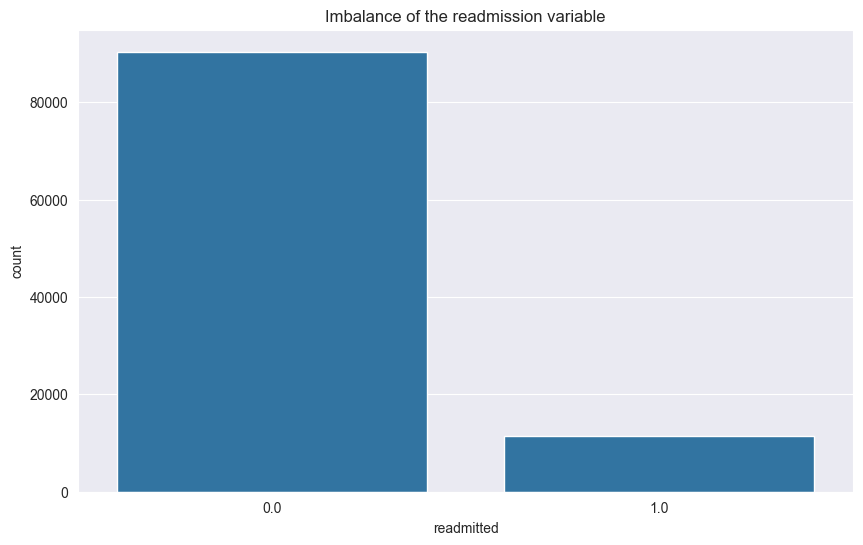

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x='readmitted', data=data)
plt.title('Imbalance of the readmission variable')
plt.show()

## Normal KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[17397   672]
 [ 2148   137]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93     18069
         1.0       0.17      0.06      0.09      2285

    accuracy                           0.86     20354
   macro avg       0.53      0.51      0.51     20354
weighted avg       0.81      0.86      0.83     20354



## Oversampling with SMOTE

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train['readmitted'].value_counts())
print("\nAfter SMOTE:")
print(y_train_oversampled['readmitted'].value_counts())

Before SMOTE:
readmitted
0.0    72340
1.0     9072
Name: count, dtype: int64

After SMOTE:
readmitted
0.0    72340
1.0    72340
Name: count, dtype: int64


### k-NN with oversampling

In [27]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_oversampled, y_train_oversampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[13061  5008]
 [ 1524   761]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     18069
         1.0       0.13      0.33      0.19      2285

    accuracy                           0.68     20354
   macro avg       0.51      0.53      0.49     20354
weighted avg       0.81      0.68      0.73     20354



## Undersampling with RandomUnderSampler

In [29]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print("Before undersampling:")
print(y_train['readmitted'].value_counts())
print("\nAfter undersampling:")
print(y_train_undersampled['readmitted'].value_counts())

Before undersampling:
readmitted
0.0    72340
1.0     9072
Name: count, dtype: int64

After undersampling:
readmitted
0.0    9072
1.0    9072
Name: count, dtype: int64


### k-NN with undersampling

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred = knn.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[9748 8321]
 [1087 1198]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.54      0.67     18069
         1.0       0.13      0.52      0.20      2285

    accuracy                           0.54     20354
   macro avg       0.51      0.53      0.44     20354
weighted avg       0.81      0.54      0.62     20354



# Results based on a range of k 

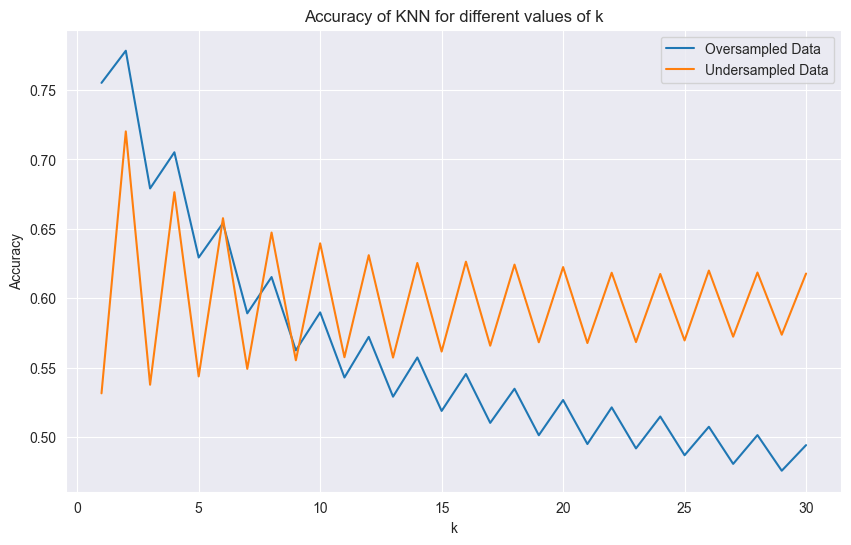

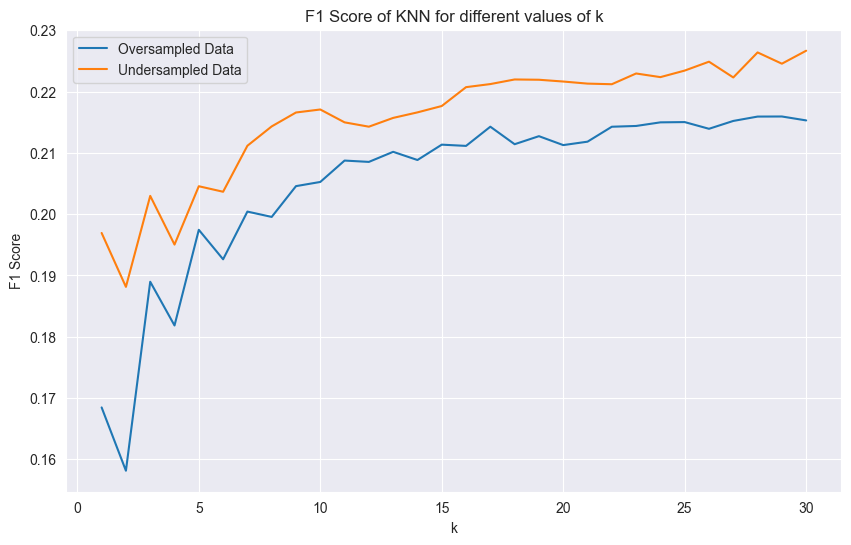

In [32]:
from sklearn.metrics import accuracy_score, f1_score

k_values = range(1, 31)

accuracy_scores_oversampling = []
accuracy_scores_undersampling = []
f1_scores_oversampling = []
f1_scores_undersampling = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # oversampling
    knn.fit(X_train_oversampled, y_train_oversampled.values.ravel())
    y_pred_oversampling = knn.predict(X_test)
    accuracy_scores_oversampling.append(accuracy_score(y_test, y_pred_oversampling))
    f1_scores_oversampling.append(f1_score(y_test, y_pred_oversampling))

    # undersampling
    knn.fit(X_train_undersampled, y_train_undersampled.values.ravel())
    y_pred_undersampling = knn.predict(X_test)
    accuracy_scores_undersampling.append(accuracy_score(y_test, y_pred_undersampling))
    f1_scores_undersampling.append(f1_score(y_test, y_pred_undersampling))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores_oversampling, label='Oversampled Data')
plt.plot(k_values, accuracy_scores_undersampling, label='Undersampled Data')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN for different values of k')
plt.legend()
plt.show()

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores_oversampling, label='Oversampled Data')
plt.plot(k_values, f1_scores_undersampling, label='Undersampled Data')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score of KNN for different values of k')
plt.legend()
plt.show()